In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from baseline import print_rules
from util import RuleClassifier
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, X_test, y_test, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# General Explanations

In [4]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
mclass_tree = DecisionTreeClassifier()
mclass_tree.fit(X, mclass_diff)
class_names = comparer.class_names[mclass_tree.classes_]

In [6]:
feature_importances = mclass_tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

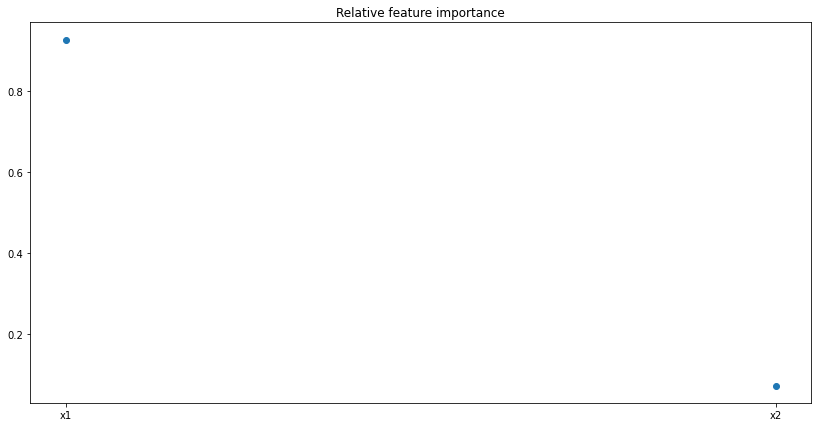

In [7]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [8]:
class_names

array(['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'], dtype='<U6')

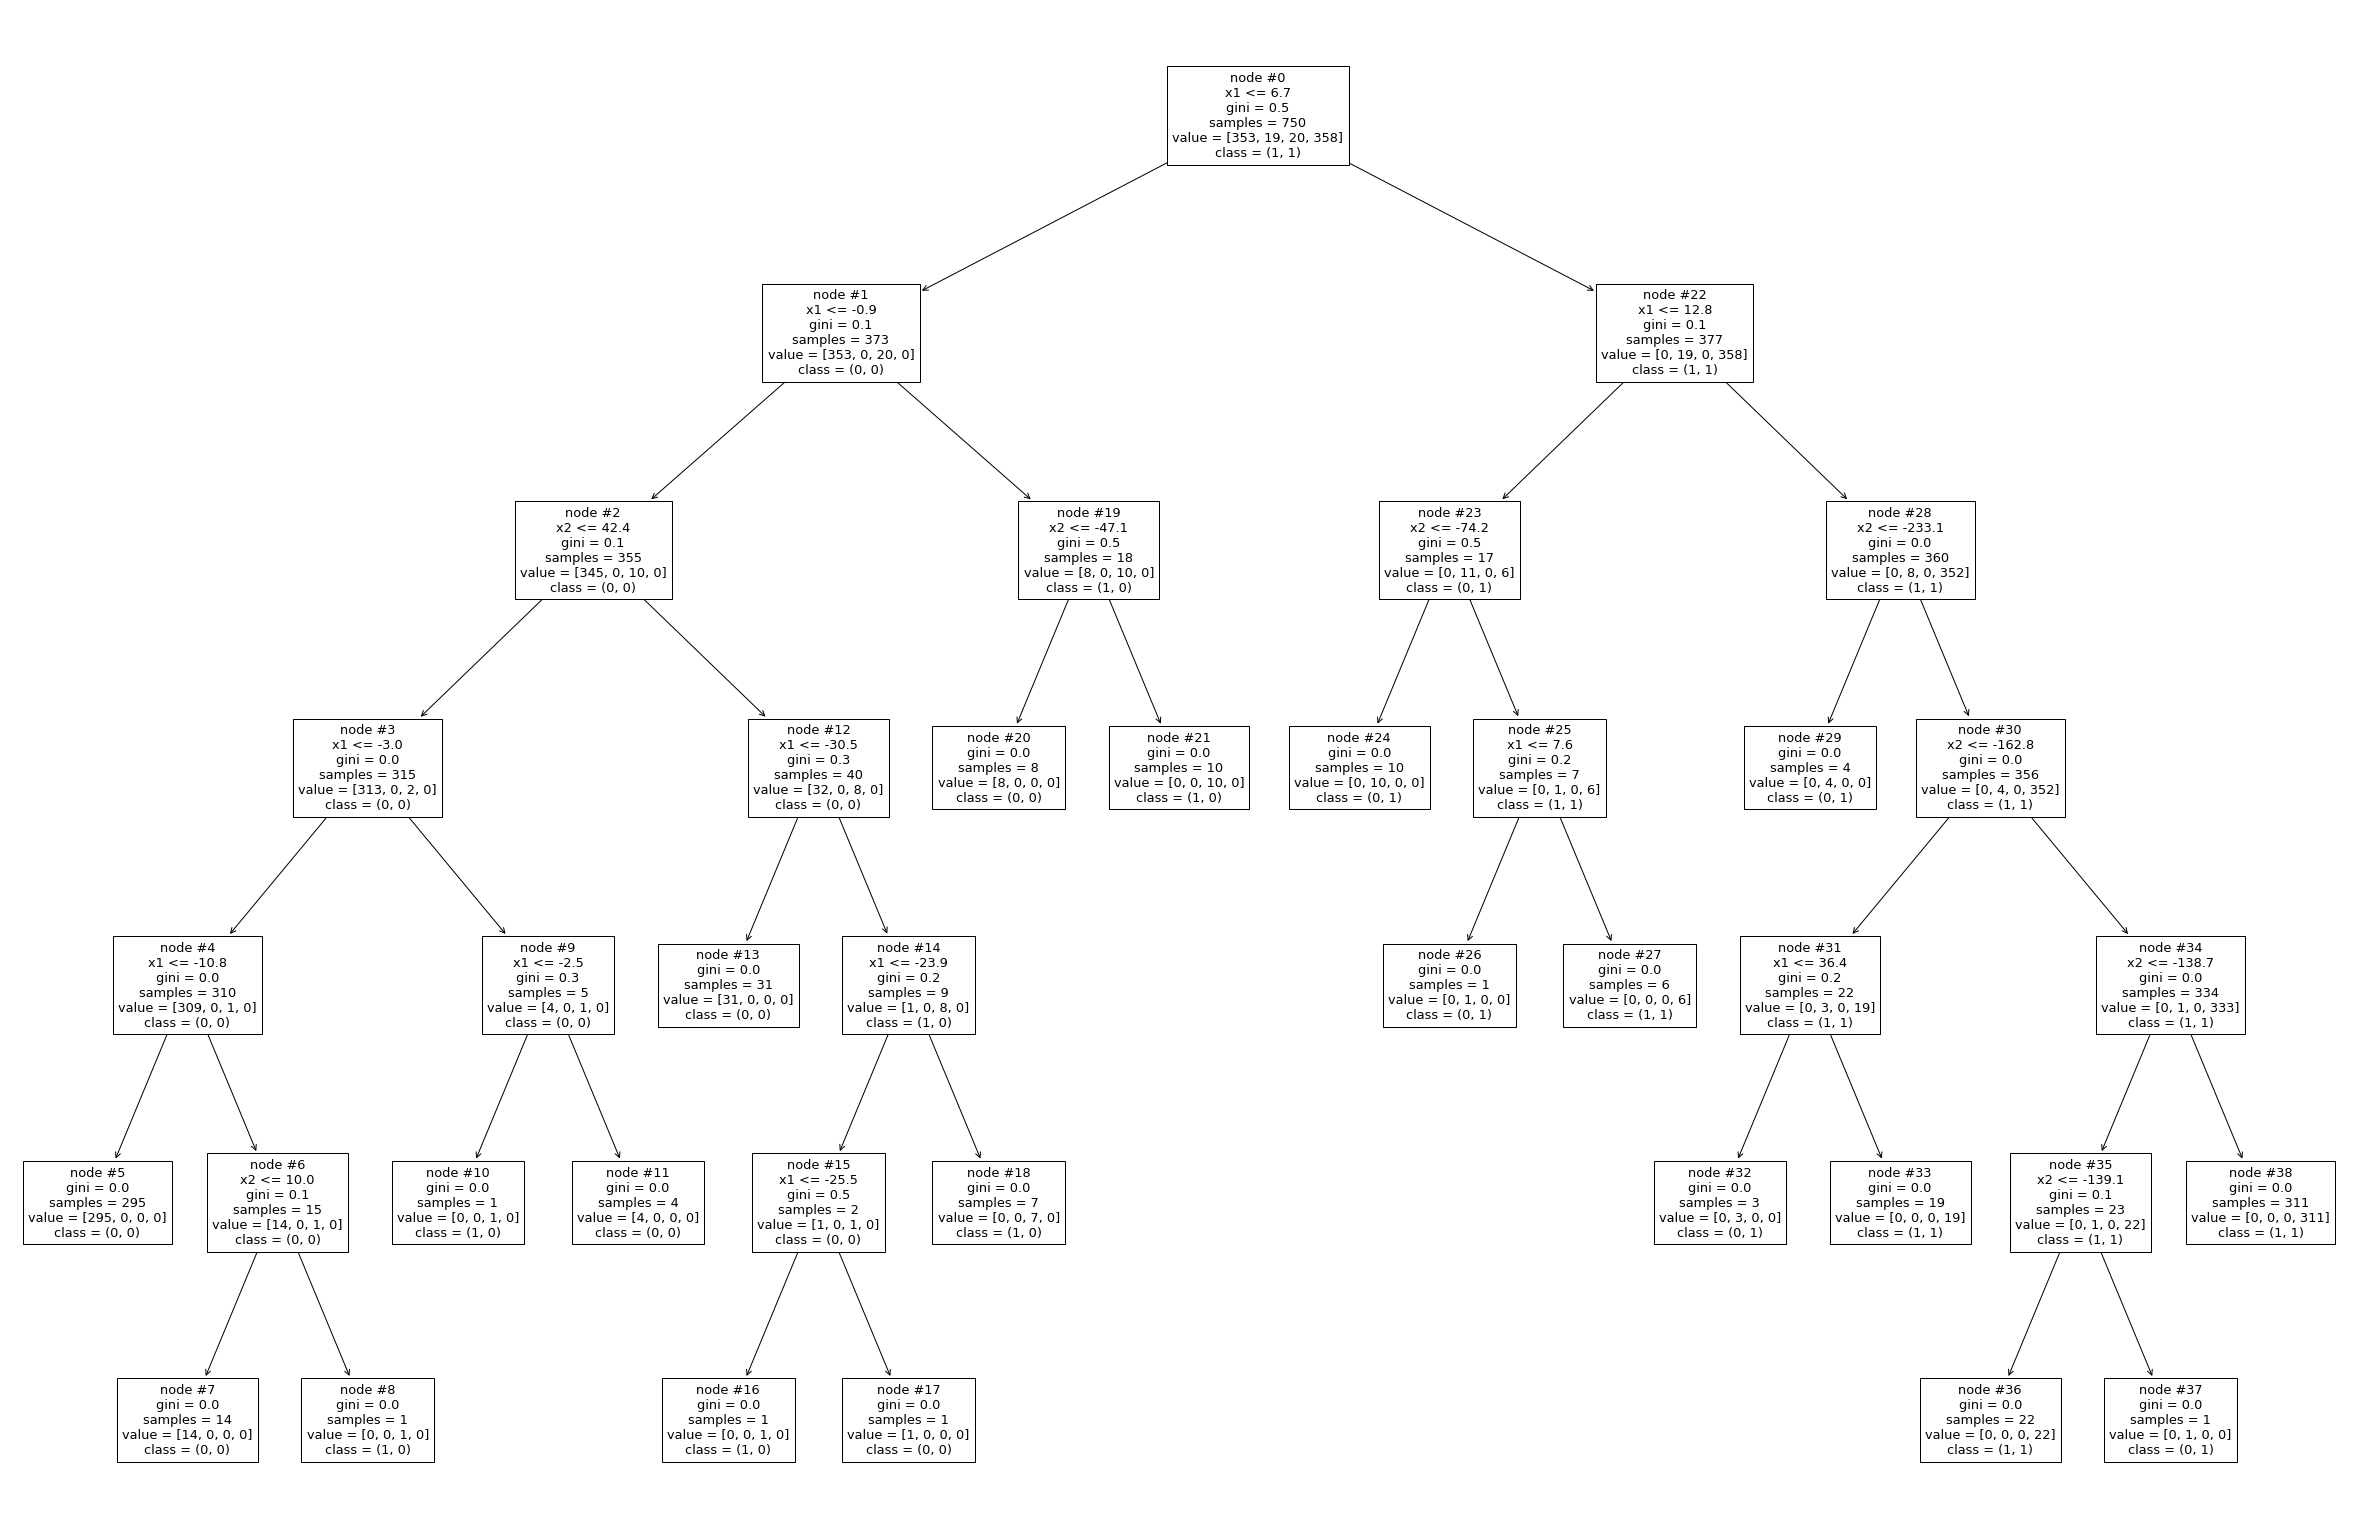

In [9]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [10]:
rules = print_rules(mclass_tree, feature_names, class_names, '(0, 1)', feature_order, precision=2)
r = RuleClassifier(feature_names, rules)

node #24: if (x1 > 6.7) and (x1 <= 12.78) and (x2 <= -74.18) then class (0, 1) (covers 1.0 of 10 instances)
node #29: if (x1 > 12.78) and (x2 <= -233.14) then class (0, 1) (covers 1.0 of 4 instances)
node #32: if (x1 > 12.78) and (x1 <= 36.44) and (x2 > -233.14) and (x2 <= -162.77) then class (0, 1) (covers 1.0 of 3 instances)
node #26: if (x1 > 6.7) and (x1 <= 7.6) and (x2 > -74.18) then class (0, 1) (covers 1.0 of 1 instances)
node #37: if (x1 > 12.78) and (x2 > -139.09) and (x2 <= -138.65) then class (0, 1) (covers 1.0 of 1 instances)


In [11]:
y_true = comparer.predict_mclass_diff(X) == np.where(comparer.class_names == '(0, 1)')[0][0]
y_pred = r.predict(X)

In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       731
        True       1.00      1.00      1.00        19

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



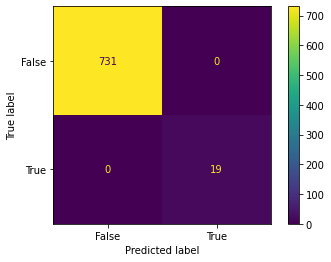

In [13]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=r.classes_)
disp.plot();

In [14]:
y_true = comparer.predict_mclass_diff(X_test) == np.where(comparer.class_names == '(0, 1)')[0][0]
y_pred = r.predict(X_test)

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2206
        True       0.78      0.66      0.72        44

    accuracy                           0.99      2250
   macro avg       0.89      0.83      0.86      2250
weighted avg       0.99      0.99      0.99      2250



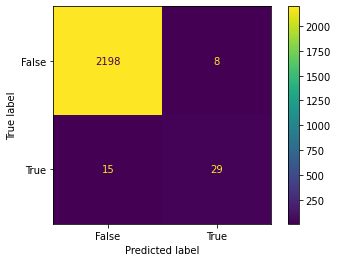

In [16]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=r.classes_)
disp.plot();

In [17]:
rules = print_rules(mclass_tree, feature_names, class_names, '(1, 0)', feature_order, precision=2)
r = RuleClassifier(feature_names, rules)

node #21: if (x1 > -0.93) and (x1 <= 6.7) and (x2 > -47.09) then class (1, 0) (covers 1.0 of 10 instances)
node #18: if (x1 > -23.95) and (x1 <= -0.93) and (x2 > 42.4) then class (1, 0) (covers 1.0 of 7 instances)
node #16: if (x1 > -30.46) and (x1 <= -25.46) and (x2 > 42.4) then class (1, 0) (covers 1.0 of 1 instances)
node #10: if (x1 > -3.02) and (x1 <= -2.5) and (x2 <= 42.4) then class (1, 0) (covers 1.0 of 1 instances)
node #8: if (x1 > -10.79) and (x1 <= -3.02) and (x2 > 9.99) and (x2 <= 42.4) then class (1, 0) (covers 1.0 of 1 instances)


In [18]:
y_true = comparer.predict_mclass_diff(X) == np.where(comparer.class_names == '(1, 0)')[0][0]
y_pred = r.predict(X)

In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       730
        True       1.00      1.00      1.00        20

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



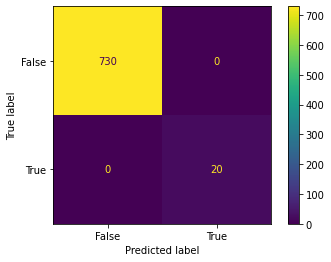

In [20]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=r.classes_)
disp.plot();

In [21]:
y_true = comparer.predict_mclass_diff(X_test) == np.where(comparer.class_names == '(1, 0)')[0][0]
y_pred = r.predict(X_test)

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      2197
        True       0.91      0.75      0.82        53

    accuracy                           0.99      2250
   macro avg       0.95      0.88      0.91      2250
weighted avg       0.99      0.99      0.99      2250



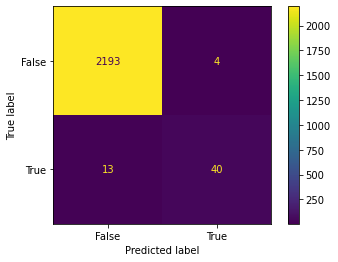

In [23]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=r.classes_)
disp.plot();